<a href="https://colab.research.google.com/github/sofiaortman/PPSortman/blob/main/CODIGO_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

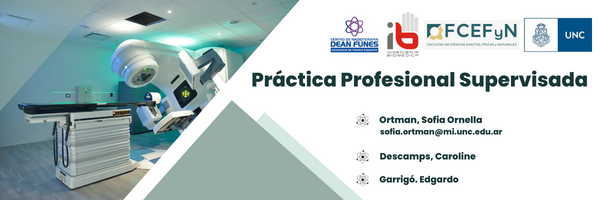

En este codigo buscamos recorrer las careptas de los pacientes donde se encuentran los archivos NIFTI sin modificar, aplicarle la modificacion de los cortes y guardarlos como tensores.

Estas líneas importan las bibliotecas necesarias para el procesamiento de archivos, manipulación de imágenes y la transformación de datos.


In [ ]:
import os
import glob
import torch
import torchvision.transforms as transforms
import numpy as np
import nibabel as nib

Aquí se definen las rutas de las carpetas raíz donde se encuentran las subcarpetas de los pacientes y la carpeta de salida donde se crearán las subcarpetas correspondientes para guardar los resultados modificados.

In [ ]:
# Ruta de la carpeta raíz donde se encuentran las subcarpetas de los pacientes
root_folder = "/content/drive/MyDrive/BASE DE DATOS/1. ARCHIVOS NIFTI"

# Ruta de la carpeta donde se crearán las subcarpetas de salida
output_root_folder = "/content/drive/MyDrive/BASE DE DATOS/2. TENSORES"

Se utiliza os.walk() para recorrer la estructura de carpetas a partir de la carpeta raíz y se obtienen los nombres de las subcarpetas (pacientes). sorted() se utiliza para asegurar que las subcarpetas se procesen en orden alfabético.

In [ ]:
# Obtener la lista de subcarpetas (pacientes) dentro de la carpeta raíz
subfolders = sorted(next(os.walk(root_folder))[1])

Se define la transformación ToTensor() de torchvision.transforms para convertir las imágenes en matrices a tensores de PyTorch.

In [ ]:
# Transformaciones para convertir la imagen a tensor y viceversa
to_tensor = transforms.ToTensor()

Se itera sobre cada subcarpeta (paciente) dentro de la carpeta raíz. Para cada subcarpeta, se construyen las rutas de la carpeta de entrada correspondiente (donde se encuentran los archivos NIfTI del paciente) y la carpeta de salida correspondiente (donde se guardarán los resultados modificados). Se utiliza os.makedirs() para crear la carpeta de salida si no existe.

Se utiliza glob.glob() para obtener la lista de archivos NIfTI dentro de la carpeta del paciente. La ruta se construye utilizando os.path.join() y se especifica "*.nii*" como patrón para seleccionar todos los archivos con extensión .nii o .nii.gz.

Se itera sobre cada archivo NIfTI en la lista. Para cada archivo, se carga utilizando nib.load() de la biblioteca nibabel. Luego, se obtienen los datos de la imagen como una matriz tridimensional utilizando nifti_image.get_fdata(). La variable slices_actual almacena el número de cortes actuales de la tomografía.

Se define el número deseado de cortes (slices_nuevos) a 128 y se crea una matriz de ceros (data_resized) con la misma forma que los datos originales, pero con el número de cortes actualizado.

Se verifica si el número de cortes actuales es mayor o igual al número deseado de cortes. Si es así, se realiza la interpolación utilizando un bucle for para generar los cortes interpolados.

Se utiliza la transformación to_tensor para convertir la matriz de datos redimensionados en un tensor de PyTorch. Luego, se obtiene el nombre del archivo sin la ruta y la extensión, y se construye la ruta de salida para el archivo de tensor. Finalmente, se guarda el tensor en un archivo utilizando torch.save().

In [ ]:
# Iterar sobre cada subcarpeta (paciente)
for subfolder in subfolders:
    patient_folder = os.path.join(root_folder, subfolder)
    output_folder = os.path.join(output_root_folder, subfolder)

    # Crear la subcarpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Obtener la lista de archivos NIfTI dentro de la subcarpeta del paciente
    nifti_files = glob.glob(os.path.join(patient_folder, "*.nii*"))

    # Iterar sobre cada archivo NIfTI
    for nifti_file in nifti_files:
        # Cargar el archivo NIfTI
        nifti_image = nib.load(nifti_file)

        # Obtener los datos como una matriz tridimensional
        data = nifti_image.get_fdata()

        # Verificar el tamaño actual de la tomografía
        slices_actual = data.shape[2]
        print("Cortes actuales:", slices_actual)

        # Redimensionar la tomografía a 128 cortes utilizando interpolación
        slices_nuevos = 128
        data_resized = np.zeros((data.shape[0], data.shape[1], slices_nuevos))

        if slices_actual >= slices_nuevos:
            for i in range(slices_nuevos):
                # Calcular el factor de escala para interpolar los cortes
                factor_escala = (slices_actual - 1) / (slices_nuevos - 1) * i

                # Interpolar los cortes
                corte_interp = np.floor(factor_escala).astype(int)
                corte_fraccion = factor_escala - corte_interp

                corte = data[:, :, corte_interp]

                if corte_interp < slices_actual - 1:
                    corte_siguiente = data[:, :, corte_interp + 1]
                else:
                    corte_siguiente = data[:, :, corte_interp]

                corte_interp = corte + (corte_siguiente - corte) * corte_fraccion
                data_resized[:, :, i] = corte_interp
        else:
            data_resized[:, :, :slices_actual] = data

        # Convertir la matriz de datos a tensor utilizando PyTorch
        tensor_data = to_tensor(data_resized)
        tensor_data = tensor_data.to(torch.float32)

        # Obtener el nombre del archivo sin la ruta y la extensión
        filename = os.path.splitext(os.path.basename(nifti_file))[0]

        # Construir la ruta de salida para el tensor
        output_file = os.path.join(output_folder, filename + ".pt")

        # Guardar el tensor como archivo
        torch.save(tensor_data, output_file)

        print("Tensor modificado guardado en:", output_file)
        print(tensor_data.shape)


Cortes actuales: 117
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/027. BUTELER/RECTO.pt
torch.Size([128, 512, 512])
Cortes actuales: 117
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/027. BUTELER/DOSIS.pt
torch.Size([128, 147, 110])
Cortes actuales: 117
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/027. BUTELER/CT.pt
torch.Size([128, 512, 512])
Cortes actuales: 117
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/027. BUTELER/VEJIGA.pt
torch.Size([128, 512, 512])
Cortes actuales: 117
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/027. BUTELER/PTV.pt
torch.Size([128, 512, 512])
Cortes actuales: 138
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORES/110. RODRIGUEZ/CT.pt
torch.Size([128, 512, 512])
Cortes actuales: 138
Tensor modificado guardado en: /content/drive/MyDrive/BASE DE DATOS/2. TENSORE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
